In [1]:
pip install tensorflow python-dotenv pandas numpy scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


## Import Necessary Libraries

In [1]:
import os
import requests
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dot, Flatten, Dense, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from dotenv import load_dotenv
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2

## Load Data

In [2]:
load_dotenv()  # Load environment variables from .env file
jwt_token = os.getenv('JWT_TOKEN')

headers = {'Authorization': f'Bearer {jwt_token}'}

api_urls = {
    'interactions': 'http://161.97.109.65:3000/api/interactions',
    'users': 'http://161.97.109.65:3000/api/users',
    'products': 'http://161.97.109.65:3000/api/products'
}

def fetch_data(url, headers):
    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status()  # Raises an HTTPError for bad requests
        data = pd.DataFrame(response.json())
        print(f"Data successfully fetched from {url}")
        print(data.head())  # Display the first few rows of the DataFrame
        return data
    except requests.RequestException as e:
        print(f'Failed to fetch data from {url}: {str(e)}')
        return pd.DataFrame()

# Fetch data from APIs
users = fetch_data(api_urls['users'], headers)
products = fetch_data(api_urls['products'], headers)
interactions = fetch_data(api_urls['interactions'], headers)

# Check if data was fetched successfully
if not users.empty and not products.empty and not interactions.empty:
    print("All data fetched successfully.")
else:
    print("Data fetching failed, check errors and retry.")
    # Optionally, add logic to halt further processing if data is crucial


Data successfully fetched from http://161.97.109.65:3000/api/users
                        _id       firstname       lastname         username  \
0  6665e9847aa0dfec0ad43b26         Machine       Learning  machinelearning   
1  6665eab57aa0dfec0ad43b2a  DummyFirstname  DummyLastname       dummydata1   
2  6665eac87aa0dfec0ad43b2d  DummyFirstname  DummyLastname       dummydata2   
3  6665eacc7aa0dfec0ad43b30  DummyFirstname  DummyLastname       dummydata3   
4  6665eacf7aa0dfec0ad43b33  DummyFirstname  DummyLastname       dummydata4   

                  email         phone  \
0          ml@admin.com    7777777777   
1  dummydata1@admin.com  777777770001   
2  dummydata2@admin.com  777777770002   
3  dummydata3@admin.com  777777770003   
4  dummydata4@admin.com  777777770004   

                                            password           address  \
0  $2a$10$oNSoSQcmxvHAefk5dKx0UuJw8oSdGeCumA.ZqIN...  Bangkit Capstone   
1  $2a$10$ihldsbescWBR9v94/sRhReBpX8mZMGrRpwkUohU...   Dummy Ad

## Data Preprocessing

In [3]:
# Let's assume 'interactions' is a DataFrame with a column containing dictionaries
# First, ensure that the 'interactions' column is appropriately normalized
if 'interactions' in interactions.columns:
    interactions_expanded = pd.json_normalize(interactions['interactions'])
else:
    interactions_expanded = pd.json_normalize(interactions.iloc[:, 0])  # If 'interactions' is the name of DataFrame and not a column

# Assuming the JSON data has keys 'userId', 'productId', and 'interactionValue'
interactions_expanded['user_id'] = interactions_expanded['userId']
interactions_expanded['product_id'] = interactions_expanded['productId']
interactions_expanded['interaction_value'] = interactions_expanded['interactionValue']

# Encode user_id and product_id
user_ids = interactions_expanded['user_id'].unique().tolist()
product_ids = interactions_expanded['product_id'].unique().tolist()

user2user_encoded = {x: i for i, x in enumerate(user_ids)}
product2product_encoded = {x: i for i, x in enumerate(product_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
productencoded2product = {i: x for i, x in enumerate(product_ids)}

interactions_expanded['user'] = interactions_expanded['user_id'].map(user2user_encoded)
interactions_expanded['product'] = interactions_expanded['product_id'].map(product2product_encoded)

# Split the data
train, test = train_test_split(interactions_expanded, test_size=0.2, random_state=42)

# Convert data into required format
x_train = [train['user'].values, train['product'].values]
y_train = train['interaction_value'].values
x_test = [test['user'].values, test['product'].values]
y_test = test['interaction_value'].values

## Define Model

In [4]:
user_input = Input(shape=(1,))
user_embedding = Embedding(len(user2user_encoded), 50)(user_input)  # Removed input_length
user_vec = Flatten()(user_embedding)

product_input = Input(shape=(1,))
product_embedding = Embedding(len(product2product_encoded), 50)(product_input)  # Removed input_length
product_vec = Flatten()(product_embedding)

dot_product = Dot(axes=1)([user_vec, product_vec])
dense = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(dot_product)
dense = Dropout(0.5)(dense)
dense = BatchNormalization()(dense)
dense = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(dense)
dense = Dropout(0.5)(dense)
dense = BatchNormalization()(dense)
dense = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(dense)
dense = Dropout(0.5)(dense)
dense = BatchNormalization()(dense)
dense = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(dense)
dense = Dropout(0.5)(dense)
dense = BatchNormalization()(dense)
dense = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(dense)
dense = Dropout(0.5)(dense)
dense = BatchNormalization()(dense)
output = Dense(1)(dense)

model = Model(inputs=[user_input, product_input], outputs=output)
model.compile(optimizer=Adam(), loss='mean_squared_error')

## Train Model

In [5]:
# Assuming 'train' and 'test' datasets are already split and preprocessed
x_train = [np.array(train['user']), np.array(train['product'])]
y_train = np.array(train['interaction_value'])

# Early stopping and learning rate scheduler callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)

# Train the model
history = model.fit(x_train, y_train, epochs=100, verbose=1, validation_split=0.2, callbacks=[early_stopping, reduce_lr])

# Optionally, you can add callbacks, for example to save the best model or early stopping
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define the path to the model directory
model_dir = os.path.join('..', 'model', 'collaborative_model.keras')

Epoch 1/100

40/40 [==============================] - 8s 49ms/step - loss: 12.6397 - val_loss: 8.9015 - lr: 0.0010
Epoch 2/100
40/40 [==============================] - 1s 30ms/step - loss: 10.6324 - val_loss: 7.4827 - lr: 0.0010
Epoch 3/100
40/40 [==============================] - 1s 24ms/step - loss: 9.2461 - val_loss: 6.5752 - lr: 0.0010
Epoch 4/100
40/40 [==============================] - 1s 25ms/step - loss: 8.2280 - val_loss: 6.0076 - lr: 0.0010
Epoch 5/100
40/40 [==============================] - 1s 21ms/step - loss: 7.3089 - val_loss: 5.6614 - lr: 0.0010
Epoch 6/100
40/40 [==============================] - 1s 21ms/step - loss: 6.7657 - val_loss: 5.3902 - lr: 0.0010
Epoch 7/100
40/40 [==============================] - 1s 21ms/step - loss: 6.4254 - val_loss: 5.2196 - lr: 0.0010
Epoch 8/100
40/40 [==============================] - 1s 25ms/step - loss: 6.2223 - val_loss: 5.0812 - lr: 0.0010
Epoch 9/100
40/40 [==============================] - 1s 24ms/step - loss: 5.9565 - val_loss: 

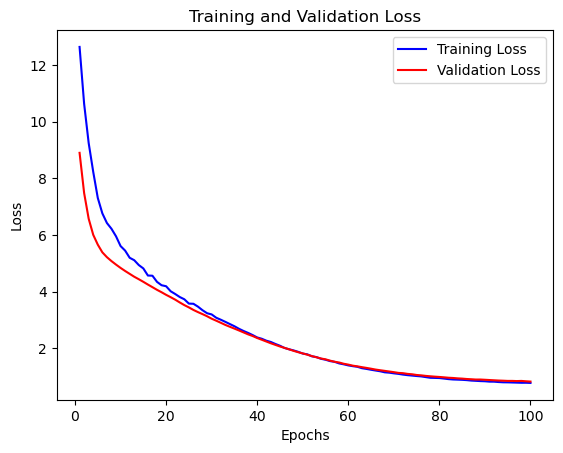

In [6]:
# Get training and validation loss history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot loss history
import matplotlib.pyplot as plt

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Try Model

In [8]:
# Function to get recommendations for a specific user
def recommend_products(user_id, model, interactions, user2user_encoded, product2product_encoded, productencoded2product, products, top_n=30):
    # Check if user_id is in the encoding map
    if user_id not in user2user_encoded:
        print(f"User ID {user_id} not found.")
        return pd.DataFrame()

    user_encoded = user2user_encoded[user_id]
    # Get all encoded product IDs as a list of integers
    product_ids = list(product2product_encoded.values())

    # Create user-product array for prediction
    # Ensure all entries are integers for the model input
    user_product_array = np.array([[user_encoded] * len(product_ids), product_ids]).T.astype(int)

    # Predict interaction values using the model
    predictions = model.predict([user_product_array[:, 0], user_product_array[:, 1]])
    predictions = predictions.flatten()

    # Get top N product indices
    top_indices = predictions.argsort()[-top_n:][::-1]
    # Decode the top indices to product IDs
    recommended_product_ids = [productencoded2product[x] for x in top_indices]
 
    # Filter the products DataFrame to get recommended products using the correct column name
    recommended_products = products[products['_id'].isin(recommended_product_ids)]
    return recommended_products

# Try the model with the specified user ID
user_id = '6665e9847aa0dfec0ad43b26'
recommended_products = recommend_products(user_id, model, interactions, user2user_encoded, product2product_encoded, productencoded2product, products)
print(f"Recommended products for user {user_id}:")
print(recommended_products)

33/33 [==============================] - 0s 6ms/step
Recommended products for user 6665e9847aa0dfec0ad43b26:
                           _id     category      price  \
27    6667ef73b3e75416b2fa7e4e         Meja    49000.0   
103   6667ef73b3e75416b2fa7e9a         Meja    65000.0   
130   6667ef73b3e75416b2fa7eb5         Meja    54000.0   
188   6667ef73b3e75416b2fa7eef         Meja    80000.0   
253   6667ef73b3e75416b2fa7f30         Meja   275000.0   
300   6667ef73b3e75416b2fa7f5f        Kasur    85400.0   
322   6667ef73b3e75416b2fa7f75        Kasur   381150.0   
364   6667ef73b3e75416b2fa7f9f        Kasur   189000.0   
387   6667ef73b3e75416b2fa7fb6        Kasur   183700.0   
390   6667ef73b3e75416b2fa7fb9        Kasur   296850.0   
428   6667ef73b3e75416b2fa7fdf  Kipas Angin    82000.0   
514   6667ef73b3e75416b2fa8035  Kipas Angin  5780000.0   
537   6667ef73b3e75416b2fa804c  Kipas Angin    52000.0   
547   6667ef73b3e75416b2fa8056  Kipas Angin    24900.0   
649   6667ef73b3e7541

In [9]:
# Save model
model_json = model.to_json()
with open("kelas_model.json", "w") as json_file:
    json_file.write(model_json)

# Save model weights in HDF5 format
model.save_weights("kelas_model_weights.h5")

In [11]:
# Load model & weights
with open("kelas_model.json", "r") as json_file:
    loaded_model_json = json_file.read()

model1 = tf.keras.models.model_from_json(loaded_model_json)
model1.load_weights("kelas_model_weights.h5")

# Compile loaded model
model1.compile(optimizer='rmsprop', loss='mean_squared_error')

In [13]:
# Function to get recommendations for a specific user
def recommend_products(user_id, model, interactions, user2user_encoded, product2product_encoded, productencoded2product, products, top_n=30):
    # Check if user_id is in the encoding map
    if user_id not in user2user_encoded:
        print(f"User ID {user_id} not found.")
        return pd.DataFrame()

    user_encoded = user2user_encoded[user_id]
    # Get all encoded product IDs as a list of integers
    product_ids = list(product2product_encoded.values())

    # Create user-product array for prediction
    # Ensure all entries are integers for the model input
    user_product_array = np.array([[user_encoded] * len(product_ids), product_ids]).T.astype(int)

    # Predict interaction values using the model
    predictions = model.predict([user_product_array[:, 0], user_product_array[:, 1]])
    predictions = predictions.flatten()

    # Get top N product indices
    top_indices = predictions.argsort()[-top_n:][::-1]
    # Decode the top indices to product IDs
    recommended_product_ids = [productencoded2product[x] for x in top_indices]
 
    # Filter the products DataFrame to get recommended products using the correct column name
    recommended_products = products[products['_id'].isin(recommended_product_ids)]
    return recommended_products

# Try the model with the specified user ID
user_id = '6665eacf7aa0dfec0ad43b33'
recommended_products = recommend_products(user_id, model1, interactions, user2user_encoded, product2product_encoded, productencoded2product, products)
print(f"Recommended products for user {user_id}:")
print(recommended_products)

33/33 [==============================] - 0s 7ms/step
Recommended products for user 6665eacf7aa0dfec0ad43b33:
                           _id     category     price  \
106   6667ef73b3e75416b2fa7e9d         Meja   43990.0   
142   6667ef73b3e75416b2fa7ec1         Meja  421000.0   
159   6667ef73b3e75416b2fa7ed2         Meja   67000.0   
177   6667ef73b3e75416b2fa7ee4         Meja  196700.0   
195   6667ef73b3e75416b2fa7ef6         Meja   80000.0   
395   6667ef73b3e75416b2fa7fbe        Kasur  390000.0   
410   6667ef73b3e75416b2fa7fcd        Kasur   62200.0   
411   6667ef73b3e75416b2fa7fce        Kasur  376000.0   
426   6667ef73b3e75416b2fa7fdd  Kipas Angin   57000.0   
485   6667ef73b3e75416b2fa8018  Kipas Angin   29999.0   
544   6667ef73b3e75416b2fa8053  Kipas Angin  149000.0   
551   6667ef73b3e75416b2fa805a  Kipas Angin  112000.0   
584   6667ef73b3e75416b2fa807b  Kipas Angin   56000.0   
596   6667ef73b3e75416b2fa8087  Kipas Angin   87000.0   
633   6667ef73b3e75416b2fa80ac  Kipa